(Placeholder for your group #)

(Placeholder for your names)

(Placeholder for your i-numbers)

**Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow)**: *list websites where you found code (or other info) as well as include information on how you used genAI tools*

# Data Analysis, Clinic 3

By completing and delivering the clinic tasks you will know how to :

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques like:
    * Cross Validation
    * Regularization
    
---
### Important Dates

- Clinic release: Tue, 18th Feb
- **Clinic due**: Fri, 28th Feb late night (wildcards possible, apply to the group)
---
##  Some rules

* For this clinic, like the previous one, we are asking you to use specific libraries that are included in the `requirements.txt`. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.

* Make sure that you include a proper amount/mix of comments, results and code. More specifically, be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice. To avoid confusion: use short comments for longer code answers.

* Back up any hypotheses and claims with data, since this is an important aspect of the course.

* Please write all your comments in English, and use meaningful variable names (as possible) in your code. 

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook. We will not run your notebook for you! 

- In continuation to the previous point, interactive plots, such as those generated using the ‘plotly’ package, should be strictly avoided! Make sure to print results and/or dataframes that confirm you have properly addressed the task.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. If you deliver other files, we will not grade anything.

* Honor code applies to these tasks. If you are not certain about an action, consult with Jerry.

**A Note from Jerry on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating (that does not only apply to LMs). Fortunately, my job is not to police, but rather to educate you. So, please consider the following:

I assume that you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!

I don't restrict the use of LMs because I see the value of being helped when coding (esp. in the context of pandas dataframes nightmare :)). Based on what we saw last year in your notebooks, it's pretty clear when you "copy" some code and then you struggle to interpret the results. This is the essence of this course and of the skills you should try build for yourself: Many people can run fancy models these days but not many people can interpret the results correctly. Try to be the latter ones.


# Context

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in the previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. You can also implement some of the techniques we discussed in class about imbalances. 

## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [1]:
#feel free to include additional libraries, as long as they are included in the requirements.txt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

In [2]:
import random
from sklearn.utils import check_random_state

SEED = 42  # Choose any fixed number

# Set random seed for NumPy (important for random number generation in many ML tasks)
np.random.seed(SEED)

# Set random seed for Python's built-in random module
random.seed(SEED)

# Set random seed for scikit-learn functions
rng = check_random_state(SEED)

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [3]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [4]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth


In [5]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

In [6]:
# Count the number of occurrences for each class (absolute and percentage)
poorhealth_counts_abs = gssdata['poorhealth'].value_counts()
poorhealth_counts_perc = poorhealth_counts_abs / len(gssdata) * 100

# Display the absolute and percentage split
print(f"People in poor health: {poorhealth_counts_abs[1]} ({poorhealth_counts_perc[1]:.2f}%)")
print(f"People not in poor health: {poorhealth_counts_abs[0]} ({poorhealth_counts_perc[0]:.2f}%)")


People in poor health: 99 (6.38%)
People not in poor health: 1452 (93.62%)


In [7]:
# Accuracy of predicting NOT poor health for everyone (in percentage)
accuracy_baseline = poorhealth_counts_perc[0]  # Majority class percentage

print(f"Baseline accuracy (predicting everyone as not in poor health): {accuracy_baseline:.2f}%")

Baseline accuracy (predicting everyone as not in poor health): 93.62%


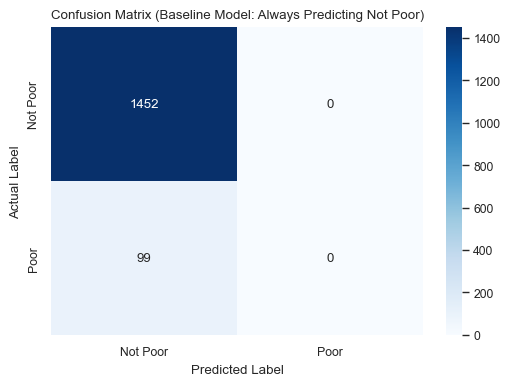

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Simulated predictions: Since we are predicting everyone as NOT in poor health (0)
y_true = gssdata['poorhealth']  # Actual values
y_pred = np.zeros_like(y_true)  # Predicted values (all 0, meaning "not poor health")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Poor", "Poor"], yticklabels=["Not Poor", "Poor"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Baseline Model: Always Predicting Not Poor)")
plt.show()


**Your answer goes here**

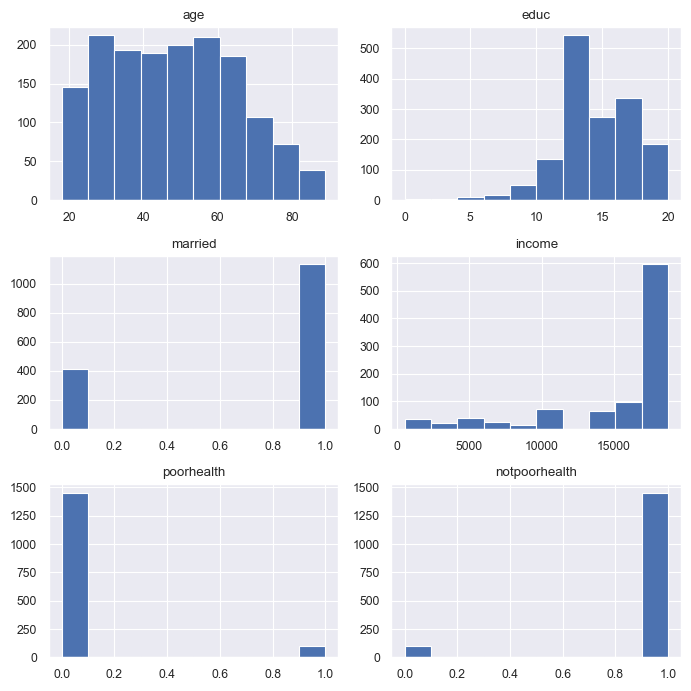

In [9]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS

gssdata.hist(figsize=(7,7))
plt.tight_layout()

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [10]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [11]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,False,True,False,False,True,False,False,False,True


### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.


Training Set Metrics:
Accuracy: 94.11%
Precision: 100.00%
Recall: 1.35%
F1-score: 2.67%

Testing Set Metrics:
Accuracy: 91.96%
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%


/opt/anaconda3/envs/data_analysis_course/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


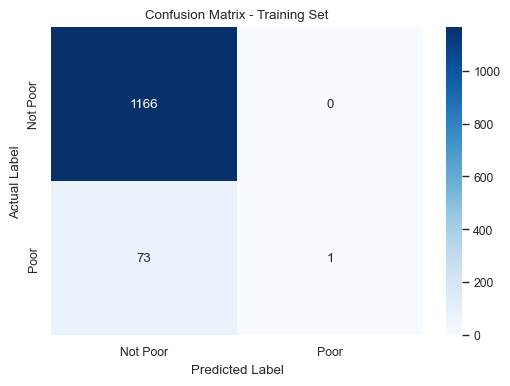

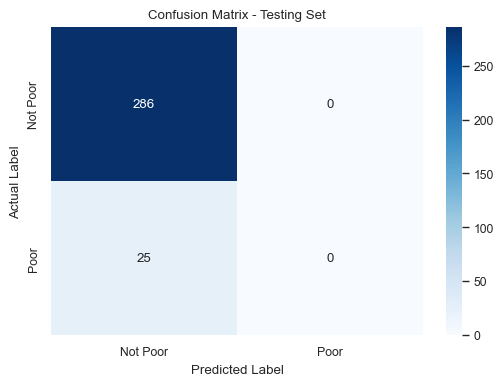

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define predictor variables (excluding 'income' due to potential missing values)
predictors = ['age', 'educ', 'female'] + list(dummy_vars.columns)

# Drop rows with missing values in predictor variables (simplification for now)
gssdata_clean = gssdata.dropna(subset=predictors + ['poorhealth'])

# Define X (features) and y (target)
X = gssdata_clean[predictors]
y = gssdata_clean['poorhealth']

# Split into train and test sets (keeping it simple, 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Ensure convergence
log_reg.fit(X_train, y_train)

# Predictions for training and testing sets
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Compute performance metrics for training and testing
def evaluate_model(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100

    print(f"\n{dataset_name} Set Metrics:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-score: {f1:.2f}%")

    return confusion_matrix(y_true, y_pred)

# Evaluate model for both training and test sets
train_cm = evaluate_model(y_train, y_train_pred, "Training")
test_cm = evaluate_model(y_test, y_test_pred, "Testing")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Poor", "Poor"], yticklabels=["Not Poor", "Poor"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()

# Plot confusion matrices for training and testing sets
plot_confusion_matrix(train_cm, "Confusion Matrix - Training Set")
plot_confusion_matrix(test_cm, "Confusion Matrix - Testing Set")


**Your answer goes here**

---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

🔍 **Step 1: Checking for Missing Values**
Total Missing Values Per Column (Before Removing Missing Data):
income    588
dtype: int64
--------------------------------------------------
📊 **Step 2: Initial Dataset Size**
Total number of samples before removing missing values: 1551
--------------------------------------------------
❌ **Step 3: Removing Missing Values**
Total number of samples dropped: 588
✔ Remaining samples after dropping missing values: 963
--------------------------------------------------
📊 **Step 4: Distribution of Poor Health Before & After**
Total poor health cases before removing missing values: 99 (6.38%)
Total poor health cases after removing missing values: 16 (1.66%)
Change in poor health cases: 83
--------------------------------------------------
🔍 **Step 5: Were Poor Health Individuals More Likely to Have Missing Income?**
Poor Health Cases in Missing Income Data: 14.12%
Not Poor Health Cases in Missing Income Data: 85.88%
----------------------------------

/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_7508/1124253225.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y="Poor Health %", data=plot_data, palette="Blues_r")


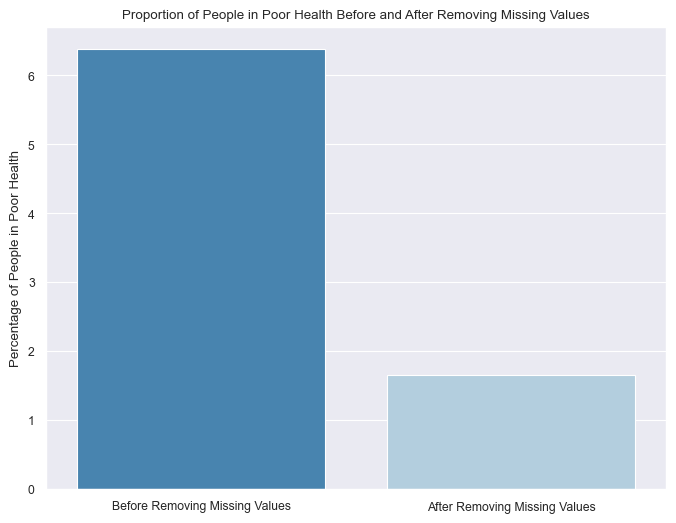

📊 **Step 6: Income Distribution Statistics**
Income Summary Before Removing Missing Values:
count      963.000000
mean     15633.177570
std       5064.191118
min        500.000000
25%      13750.000000
50%      18750.000000
75%      18750.000000
max      18750.000000
Name: income, dtype: float64
--------------------------------------------------
Income Summary After Removing Missing Values:
count      963.000000
mean     15633.177570
std       5064.191118
min        500.000000
25%      13750.000000
50%      18750.000000
75%      18750.000000
max      18750.000000
Name: income, dtype: float64
--------------------------------------------------
📉 **Step 7: Changes in Income Distribution**
Mean Income Before: 15633.18, After: 15633.18
Median Income Before: 18750.00, After: 18750.00
Min Income Before: 500.00, After: 500.00
Max Income Before: 18750.00, After: 18750.00
Standard Deviation Before: 5064.19, After: 5064.19
--------------------------------------------------


/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_7508/1124253225.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="data_status", y="income", data=income_plot_data, showfliers=False, palette="Blues_r")


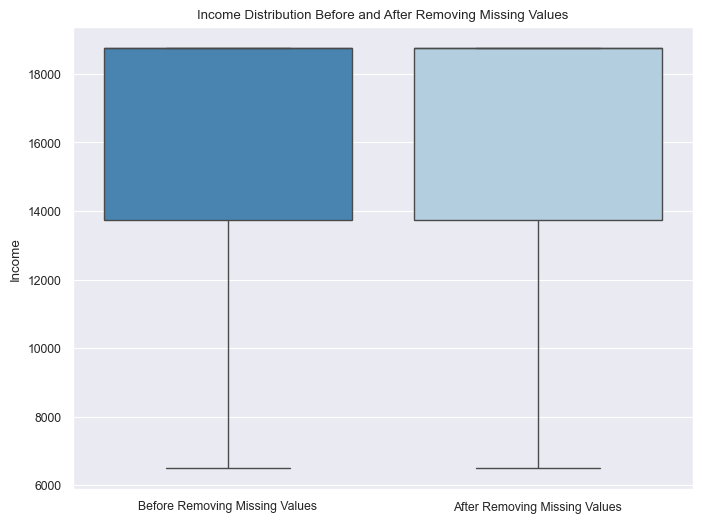

/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_7508/1124253225.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="data_status", y="age", data=age_plot_data, showfliers=False, palette="Blues_r")


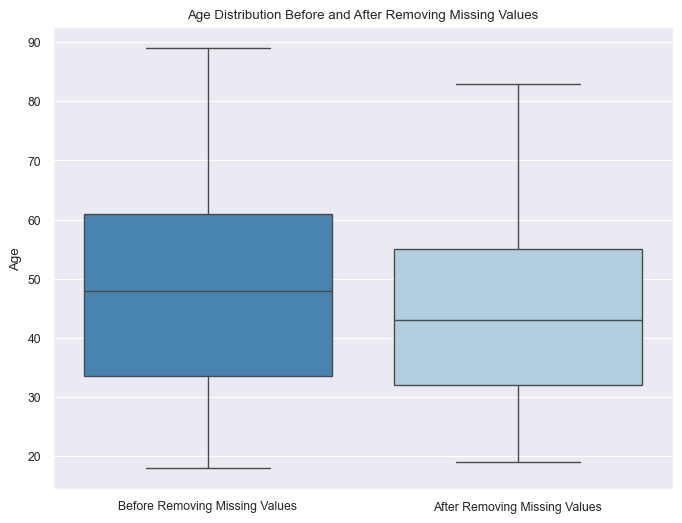

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify missing values
missing_values = gssdata.isna().sum()
missing_values = missing_values[missing_values > 0]  # Keep only columns with NaNs

# Display missing values report
print("🔍 **Step 1: Checking for Missing Values**")
print("Total Missing Values Per Column (Before Removing Missing Data):")
print(missing_values)
print("-" * 50)

# Step 2: Count initial number of observations
initial_count = gssdata.shape[0]
print(f"📊 **Step 2: Initial Dataset Size**")
print(f"Total number of samples before removing missing values: {initial_count}")
print("-" * 50)

# Step 3: Remove all rows with missing values
gssdata_full = gssdata.dropna()

# Step 4: Count observations after removal
final_count = gssdata_full.shape[0]
samples_dropped = initial_count - final_count

print(f"❌ **Step 3: Removing Missing Values**")
print(f"Total number of samples dropped: {samples_dropped}")
print(f"✔ Remaining samples after dropping missing values: {final_count}")
print("-" * 50)

# Step 5: Effect on poor health individuals
poorhealth_before = gssdata['poorhealth'].value_counts()
poorhealth_after = gssdata_full['poorhealth'].value_counts()

poorhealth_before_percent = gssdata['poorhealth'].value_counts(normalize=True) * 100
poorhealth_after_percent = gssdata_full['poorhealth'].value_counts(normalize=True) * 100

print(f"📊 **Step 4: Distribution of Poor Health Before & After**")
print(f"Total poor health cases before removing missing values: {poorhealth_before[1]} ({poorhealth_before_percent[1]:.2f}%)")
print(f"Total poor health cases after removing missing values: {poorhealth_after[1]} ({poorhealth_after_percent[1]:.2f}%)")
print(f"Change in poor health cases: {poorhealth_before[1] - poorhealth_after[1]}")
print("-" * 50)

# Step 6: Additional analysis – Were poor health individuals more likely to have missing income?
missing_income_poor_health = gssdata[gssdata['income'].isna()]['poorhealth'].value_counts(normalize=True) * 100

print(f"🔍 **Step 5: Were Poor Health Individuals More Likely to Have Missing Income?**")
print(f"Poor Health Cases in Missing Income Data: {missing_income_poor_health.get(1, 0):.2f}%")
print(f"Not Poor Health Cases in Missing Income Data: {missing_income_poor_health.get(0, 0):.2f}%")
print("-" * 50)

# Step 7: Visualization - Compare poor health distribution before and after removing missing values
plt.figure(figsize=(8, 6))

# Create a bar plot to show the proportion of poor health before and after
plot_data = pd.DataFrame({
    "Dataset": ["Before Removing Missing Values", "After Removing Missing Values"],
    "Poor Health %": [poorhealth_before_percent[1], poorhealth_after_percent[1]]
})

sns.barplot(x="Dataset", y="Poor Health %", data=plot_data, palette="Blues_r")

# Label axes
plt.ylabel("Percentage of People in Poor Health")
plt.xlabel("")
plt.title("Proportion of People in Poor Health Before and After Removing Missing Values")
plt.show()

# Step 8: Compute and display income summary statistics
income_stats_before = gssdata['income'].describe()
income_stats_after = gssdata_full['income'].describe()

print("📊 **Step 6: Income Distribution Statistics**")
print("Income Summary Before Removing Missing Values:")
print(income_stats_before)
print("-" * 50)

print("Income Summary After Removing Missing Values:")
print(income_stats_after)
print("-" * 50)

print("📉 **Step 7: Changes in Income Distribution**")
print(f"Mean Income Before: {income_stats_before['mean']:.2f}, After: {income_stats_after['mean']:.2f}")
print(f"Median Income Before: {income_stats_before['50%']:.2f}, After: {income_stats_after['50%']:.2f}")
print(f"Min Income Before: {income_stats_before['min']:.2f}, After: {income_stats_after['min']:.2f}")
print(f"Max Income Before: {income_stats_before['max']:.2f}, After: {income_stats_after['max']:.2f}")
print(f"Standard Deviation Before: {income_stats_before['std']:.2f}, After: {income_stats_after['std']:.2f}")
print("-" * 50)

# Step 9: Boxplot for Income Before & After Removing Missing Values
plt.figure(figsize=(8, 6))

# Prepare the data for boxplot
gssdata_clean = gssdata[['income']].dropna().copy()
gssdata_clean['data_status'] = "Before Removing Missing Values"

gssdata_full_clean = gssdata_full[['income']].copy()
gssdata_full_clean['data_status'] = "After Removing Missing Values"

income_plot_data = pd.concat([gssdata_clean, gssdata_full_clean])

# Create the boxplot
sns.boxplot(x="data_status", y="income", data=income_plot_data, showfliers=False, palette="Blues_r")

# Label axes
plt.ylabel("Income")
plt.xlabel("")
plt.title("Income Distribution Before and After Removing Missing Values")
plt.show()

# Step 10: Boxplot for Age Before & After Removing Missing Values
plt.figure(figsize=(8, 6))

# Prepare the data for boxplot
gssdata_age_clean = gssdata[['age']].dropna().copy()
gssdata_age_clean['data_status'] = "Before Removing Missing Values"

gssdata_full_age_clean = gssdata_full[['age']].copy()
gssdata_full_age_clean['data_status'] = "After Removing Missing Values"

age_plot_data = pd.concat([gssdata_age_clean, gssdata_full_age_clean])

# Create the boxplot
sns.boxplot(x="data_status", y="age", data=age_plot_data, showfliers=False, palette="Blues_r")

# Label axes
plt.ylabel("Age")
plt.xlabel("")
plt.title("Age Distribution Before and After Removing Missing Values")
plt.show()


In [14]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

**Your answer goes here**

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define and fit the logistic regression model (No Regularization)
logit1 = LogisticRegression(C=1000000, max_iter=1000, random_state=42)  # High C value disables regularization
logit1.fit(X_train, y_train)

# Step 2: Make predictions on training and test sets
y_train_pred = logit1.predict(X_train)
y_test_pred = logit1.predict(X_test)

# Step 3: Compute evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print Performance Metrics
print("📊 **Logistic Regression Model Performance**")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("-" * 50)

print("🔍 **Precision, Recall, and F1-Score**")
print(f"Training Precision: {train_precision:.2f} | Test Precision: {test_precision:.2f}")
print(f"Training Recall: {train_recall:.2f} | Test Recall: {test_recall:.2f}")
print(f"Training F1 Score: {train_f1:.2f} | Test F1 Score: {test_f1:.2f}")
print("-" * 50)


📊 **Logistic Regression Model Performance**
Training Accuracy: 98.61%
Test Accuracy: 97.51%
--------------------------------------------------
🔍 **Precision, Recall, and F1-Score**
Training Precision: 0.00 | Test Precision: 0.00
Training Recall: 0.00 | Test Recall: 0.00
Training F1 Score: 0.00 | Test F1 Score: 0.00
--------------------------------------------------


/opt/anaconda3/envs/data_analysis_course/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/data_analysis_course/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Your answer goes here**

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [16]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit1.predict(X_test)))

[[235   0]
 [  6   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [17]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [18]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit1, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[225  10]
 [  6   0]]
[[681  31]
 [  7   3]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [19]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

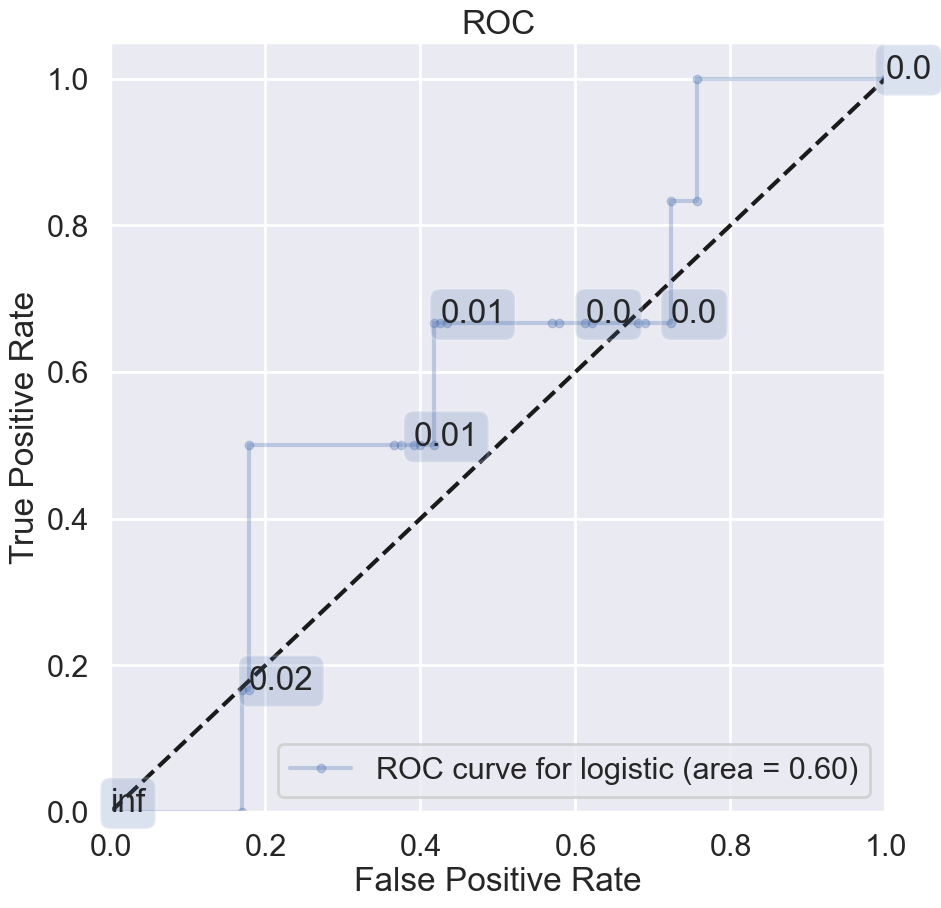

In [20]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit1, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**Your answer goes here**

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

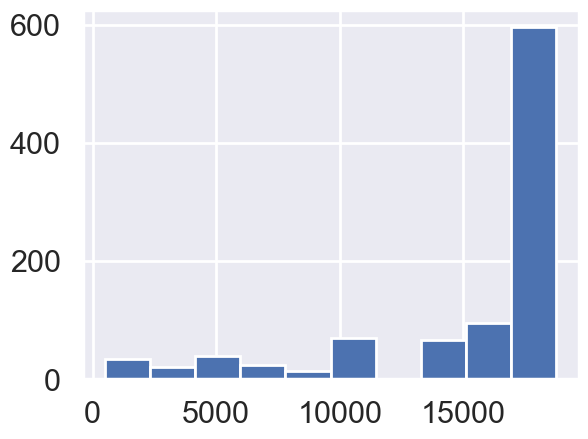

In [21]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

In [22]:
# Step 1: Count missing values for each column
missing_values = gssdata.isna().sum()

# Step 2: Filter only columns with missing values
missing_summary = missing_values[missing_values > 0]

# Step 3: Calculate percentage of missing values
missing_percentage = (missing_summary / len(gssdata)) * 100

# Step 4: Display the missing values report
missing_report = pd.DataFrame({'Missing Values': missing_summary, 'Percentage': missing_percentage})

# Print missing values
print("🔍 **Missing Values Report:**")
print(missing_report)

🔍 **Missing Values Report:**
        Missing Values  Percentage
income             588   37.911025


In [23]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
###YOUR CODE HERE
###
###
# Step 1: Copy the original dataset (before removing missing values)
gssdata_imputed = gssdata.copy()

# Step 2: Impute missing values in 'income' with the mean
income_mean = gssdata_imputed['income'].mean()
gssdata_imputed['income'].fillna(income_mean, inplace=True)

print(f" Missing values in 'income' have been replaced with the mean: {income_mean:.2f}")


 Missing values in 'income' have been replaced with the mean: 15633.18


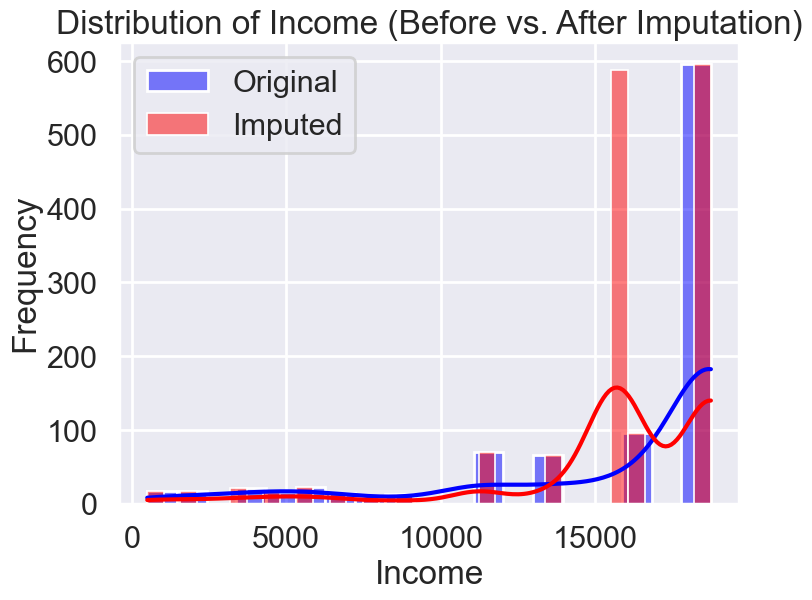

In [24]:
# Step 3: Plot histograms of income before and after imputation
plt.figure(figsize=(8, 6))
sns.histplot(gssdata['income'].dropna(), label="Original", kde=True, color='blue', alpha=0.5)
sns.histplot(gssdata_imputed['income'], label="Imputed", kde=True, color='red', alpha=0.5)
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Distribution of Income (Before vs. After Imputation)")
plt.legend()
plt.show()


In [25]:
# Step 1: Drop redundant categorical columns (original non-encoded variables)
columns_to_drop = ['health', 'sex', 'sexornt', 'notpoorhealth', 'partyid']  # Now also dropping 'partyid'
gssdata_imputed = gssdata_imputed.drop(columns=columns_to_drop, errors='ignore')

# Step 2: Define X (features) - All Columns Except 'poorhealth' (Target)
X = gssdata_imputed.drop(columns=['poorhealth'])
y = gssdata_imputed['poorhealth']

# Step 3: Convert Remaining Categorical Variables to One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)  # Converts categorical variables to numerical

# Step 4: Train/Test Split (Using Fixed Random State for Reproducibility & Stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Train Logistic Regression Model
logit_model = LogisticRegression(C=1000000, max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

# Step 6: Make Predictions
y_train_pred = logit_model.predict(X_train)
y_test_pred = logit_model.predict(X_test)

# Step 7: Evaluate Model Performance
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

train_precision = precision_score(y_train, y_train_pred, zero_division=0)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)

train_recall = recall_score(y_train, y_train_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)

train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Step 8: Print Results
print("📊 **Logistic Regression Model Performance**")
print(f"✅ Training Accuracy: {train_accuracy:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")
print("--------------------------------------------------")
print("🔍 **Precision, Recall, and F1-Score**")
print(f"Training Precision: {train_precision:.2f} | Test Precision: {test_precision:.2f}")
print(f"Training Recall: {train_recall:.2f} | Test Recall: {test_recall:.2f}")
print(f"Training F1 Score: {train_f1:.2f} | Test F1 Score: {test_f1:.2f}")
print("--------------------------------------------------")

# Step 9: Print Shapes of Train/Test Data
print("\n📊 **Data Splits:**")
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")


📊 **Logistic Regression Model Performance**
✅ Training Accuracy: 93.63%
✅ Test Accuracy: 93.57%
--------------------------------------------------
🔍 **Precision, Recall, and F1-Score**
Training Precision: 0.50 | Test Precision: 0.00
Training Recall: 0.03 | Test Recall: 0.00
Training F1 Score: 0.05 | Test F1 Score: 0.00
--------------------------------------------------

📊 **Data Splits:**
X_train Shape: (1240, 17)
X_test Shape: (311, 17)
y_train Shape: (1240,)
y_test Shape: (311,)


In [26]:
X.head()

,age,educ,married,income,female,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white,race_other,race_white
0,53,16,1,18750.00000,0,False,False,True,False,False,False,True,False,False,True,False,True
1,26,16,1,18750.00000,1,False,False,True,False,False,False,True,False,False,True,False,True
2,59,13,1,15633.17757,0,False,False,True,False,False,False,True,False,False,True,False,True
3,74,17,1,15633.17757,1,False,False,True,False,False,True,False,False,False,True,False,True
4,37,10,0,15633.17757,1,False,False,True,False,False,True,False,False,False,True,False,True


In [27]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: poorhealth, dtype: int64

In [28]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################
# Define thresholds to test
thresholds = [0.5, 0.2, 0.1, 0.06, 0.02, 0.01]

# Generate confusion matrices for each threshold
for t in thresholds:
    y_test_pred_adj = t_repredict(logit_model, t, X_test)
    print(f"\n🔍 **Confusion Matrix for Threshold = {t}**")
    print(confusion_matrix(y_test, y_test_pred_adj))



🔍 **Confusion Matrix for Threshold = 0.5**
[[291   0]
 [ 20   0]]

🔍 **Confusion Matrix for Threshold = 0.2**
[[284   7]
 [ 16   4]]

🔍 **Confusion Matrix for Threshold = 0.1**
[[242  49]
 [ 11   9]]

🔍 **Confusion Matrix for Threshold = 0.06**
[[180 111]
 [  5  15]]

🔍 **Confusion Matrix for Threshold = 0.02**
[[ 51 240]
 [  0  20]]

🔍 **Confusion Matrix for Threshold = 0.01**
[[ 10 281]
 [  0  20]]


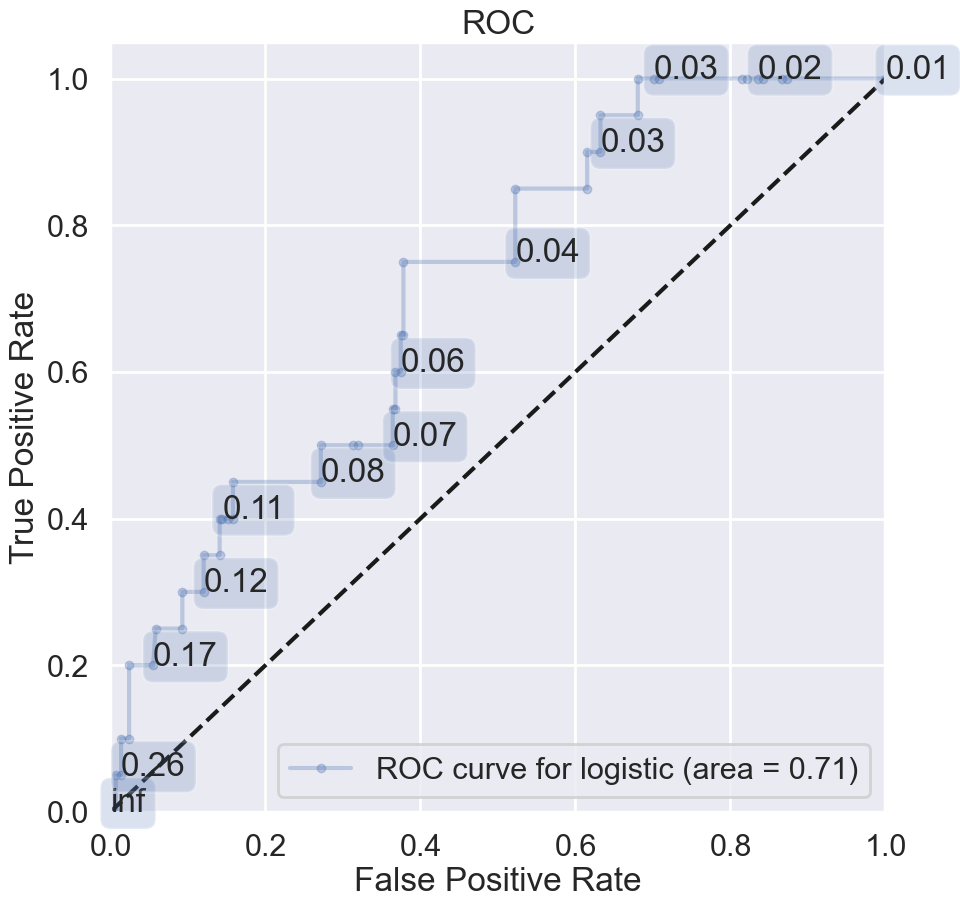

In [29]:
#####################
# your code here: create an ROC curve
#####################
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(10,10))
ax = make_roc("logistic", logit_model, y_test, X_test, labe=4, skip=0)
plt.show()


### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [ ]:
#use the dataset without NAs here
#train a model

#####################
# your code here: 

#####################

Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [ ]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = income, index = missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

In [ ]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [ ]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)
###here, do a proper train/test split and a model training

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

In [ ]:
#here you fit a model
#should be called logit3

In [ ]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
#here add code
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

For this question, you are also free (but not onbliged) to use techniques to address class imbalances (as we discussed in class) both on the data or model level. Recall that each method has advantages and disadvantages, so you will need to correctly interpret the results and assess the performance of any method you choose on the problem we explore here. Some examples can be found [here](https://imbalanced-learn.org/stable/index.html). 

In [ ]:
## your code goes here